In [58]:
# imports 
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
import time
seed = 1
np.random.seed(seed)

# from matplotlib.font_manager import FontProperties
# from matplotlib.ticker import MaxNLocator
# import matplotlib
# fontP = FontProperties()
# fontP.set_size('xx-small')
# matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['grid.alpha'] = 0.5
# plt.rc('grid', linestyle="--", color='grey')
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');
# figsize = (12,8)


plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.dpi'] = 80

In [59]:
hidden_u = []
m = 100
dim = 2
bounds = [1.6, 4]
# bounds = [2, 2]
n = 90
batch_n = 90
buff = None
epochs = 3000
tol = 1e-5
# vector field 2d from paper
# van poole equation
def vf(x):
    y = [-x[:,1], x[:,0] - (1-x[:,0]**2)*x[:,1]]
    return y

# def vf(x):
#     y1s = []
#     y2s = []
#     for i in x[:,0]:
#         if i != 0:
#             y1 = - i**2*dim / np.sin(i)
#         else:
#             y1 = 0.
#         y1s.append(y1)
#     for i in x[:,1]:
#         if i != 0:
#             y2 = - i**2*dim / np.sin(i)
#         else:
#             y2 = 0.
#         y2s.append(y2)
#     return [y1s, y2s]

In [60]:
def get_regularised_bn_mlp(input_shape, m, hidden_units, l2_reg_coeff = None, dropout_rate = None):
    """
    This function is used to build the MLP model. It takes input_shape and hidden_units
    as arguments, which should be used to build the model as described above, using the
    functional API.
    Your function should return the model.
    """
    inputs = tf.keras.layers.Input(shape=(input_shape,), name = 'state')
    h = inputs
    h = tf.keras.layers.Dense(m, activation=tf.math.cos, 
                              kernel_initializer=tf.random_normal_initializer,
                              bias_initializer= tf.random_uniform_initializer(0, 2*  np.pi), 
                              trainable=False, name = '1st_hidden')(inputs)
    h = np.sqrt(2) * h 
    for units in hidden_units:
        h = tf.keras.layers.Dense(units, activation='linear')(h)
    # use bias is false because the derivative of a constant number (bias) is just zero
    outputs = tf.keras.layers.Dense(1, kernel_initializer = tf.zeros_initializer(),activation=None, name = 'output_layer', use_bias=False, trainable=True)(h)
    outputs = outputs / m 
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = get_regularised_bn_mlp(input_shape=dim, m = m, hidden_units= hidden_u)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 state (InputLayer)          [(None, 2)]               0         
                                                                 
 1st_hidden (Dense)          (None, 100)               300       
                                                                 
 tf.math.multiply_3 (TFOpLam  (None, 100)              0         
 bda)                                                            
                                                                 
 output_layer (Dense)        (None, 1)                 100       
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                                 
Total params: 400
Trainable params: 100
Non-trainable param

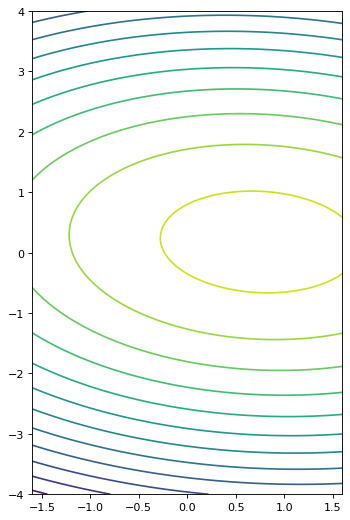

In [61]:
"""Simply plot the Layer without any training to see its initial state"""
x = np.linspace(-bounds[0], bounds[0], n)
y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
phi_0 = intermediate_output1(tf.zeros((n, dim)))
# just take the 1st row (all of the others are the same)
phi_0 = phi_0[0]
phi_y = intermediate_output1(DT)
# # check that just a random phi_y would not give the same shape
# phi_y = tf.random.uniform((phi_y.shape))

all1 = tf.tensordot(phi_y, phi_0, 1)

all2 = tf.reshape(all1, (n, n))

plt.figure(figsize=(5,8))
plt.contour(x,y, all2, levels=15)
plt.show()


In [62]:
# def kernel(x, y):
#     # x and y are two dimensional
#     intermediate_output = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
#     phi_x = intermediate_output(x)
#     phi_y = intermediate_output(y)
#     kernel_xy = phi_x * phi_y
#     return kernel_xy

# my_kernel = np.empty((n,n))

# xs = np.zeros((n,dim))
# ys = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

# for ind1, i in enumerate(xs):
#     i = i[tf.newaxis, ...]
#     for ind2, j in enumerate(ys):
#         # print(i[tf.newaxis, ...])
#         # print(j.reshape((1,2)))
#         j = j[tf.newaxis, ...]
#         # print(i.shape)
#         # print(j.shape)
#         # print(kernel(i[tf.newaxis, ...],j.reshape((1,2))))
#         # print(kernel(i,j).shape)
#         # print('----')
#         my_kernel[ind1, ind2] = kernel(i,j)
# my_kernel


In [63]:
# # trial_data = np.array([np.random.uniform(-bounds[0], bounds[0],n), np.random.uniform(-bounds[1],bounds[1],n)]).T

# trial_data = np.array([np.linspace(-1.6,1.6, n),np.linspace(-4,4, n)]).T

# intermediate_output1 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
# phi_0 = intermediate_output1(tf.zeros((n, dim)))
# phi_0 = phi_0[0]
# # phi_0

In [64]:
# intermediate_output2 = tf.keras.Model(model.input, model.get_layer('1st_hidden').output)
# # phi_y = intermediate_output2(trial_data)
# phi_y = intermediate_output1(DT)
# # phi_y

# # Zp = np.zeros(s)
# # c = 0
# # for i in range(s[0]):
# #     for j in range(s[1]):
# #         print(phi_y[c].shape)
# #         Zp[i,j] = phi_y[c]
# #         c = c+1;
# phi_y.shape

In [65]:
# # # this is the inner product (nope)
# # inn_p = phi_0 * phi_y

# # all1 = tf.tensordot(inn_p, tf.transpose(inn_p), 1)
# all1 = tf.tensordot(phi_y, phi_0, 1)
# # print(all1)
# # all1, all2 = np.array(np.meshgrid(all1, all1))
# all1

In [66]:
# XX,YY = np.meshgrid(trial_data[:,0],trial_data[:,1])
# fig = plt.figure(figsize=(5, 8))
# plt.scatter(trial_data[:,0], trial_data[:,1],all1)

In [67]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# ax.scatter(trial_data[:,0],trial_data[:,1], all1)
# plt.show()

In [68]:
# K_trial = tf.tensordot(phi_0, tf.transpose(phi_y), axes = 1)
# x = np.linspace(-4,4, n)
# plt.contour(trial_data[:,0], trial_data[:,1], K_trial)
# # plt.contour(x, x, K_trial)

In [69]:
# np.sort(np.array([np.random.uniform(-bounds[0], bounds[0],20), np.random.uniform(-bounds[1],bounds[1],20)]).T, 0)
# np.random.seed(22)
x = np.random.uniform(-bounds[0], bounds[0], n)
y = np.random.uniform(-bounds[1], bounds[1], n)

# x = np.linspace(-bounds[0], bounds[0], n)
# y = np.linspace(-bounds[1], bounds[1], n)

X, Y = np.meshgrid(x, y)

s = X.shape
train_data = np.zeros((n**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        train_data[c,0] = X[i,j]
        train_data[c,1] = Y[i,j]
        c = c+1;

vfdata = vf(train_data)
tdata = tf.convert_to_tensor(train_data, dtype=tf.float32)
tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))

train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
if buff:
    train_dataset_raw = train_dataset_raw.shuffle(buffer_size=buff)
    
train_dataset_raw = train_dataset_raw.batch(batch_n)
# Inspect data if you want
# for d, myvf in train_dataset_raw.take(2):
#     print(d)
#     print(myvf)
#     print('--')

In [70]:
# Custom tensorflow functions for loss and training

# define the part of the loss function implementing the PDE
from sklearn.model_selection import learning_curve


@tf.function
def grad_loss_eq(gradx, x_batch_train, vf_batch_train):
    # LHS of eq 6.4
    # divided by D
    g_loss = kb.sum(kb.square(kb.sum(gradx*vf_batch_train,axis=1) + kb.sum(kb.square(x_batch_train),axis=1))) / len(x_batch_train)
    return g_loss

# with the division by m, lr should be 0.5 for trainable = False
opt = tf.keras.optimizers.Adam(learning_rate=0.5)
sgd = tf.keras.optimizers.SGD(learning_rate=0.000005, nesterov=True)
gradweight = 1
# this function performs the optimization for a train step
@tf.function
def train_step(x_batch_train, vf_batch_train):

# start gradient recording for derivative w.r.t. model parameters
  with tf.GradientTape() as tape:
    tape.watch(x_batch_train)

    # evaluate model
    # try trainable = False
    logits = model(x_batch_train)

    # start gradient recording for derivative w.r.t. x
    with tf.GradientTape() as tapex:

      # prepare for evaluation of x-derivative
      tapex.watch(x_batch_train)
      # not sure if training should be false here.
      logits2 = model(x_batch_train)

      # evaluate x-derivative
      gradx = tapex.gradient(logits2, x_batch_train)

      # evaluate PDE part of loss function
      gloss = grad_loss_eq(gradx, x_batch_train, vf_batch_train)
      # this is the w in the loss equation   
      loss_value =  gradweight * gloss

    # evaluate derivative w.r.t. model parameters
    #changed this
  grads = tape.gradient(loss_value, model.trainable_weights)

    # Run one step of gradient descent optimizer
    #changed this
  opt.apply_gradients(zip(grads, model.trainable_weights))
  # sgd.apply_gradients(zip(grads, model.trainable_weights))

  return(loss_value,gloss)


@tf.function
def test_step(x_test, vf_test):

  y_pred = model(x_test, training=False)

  with tf.GradientTape() as tapex:

    tapex.watch(x_test)
    # not sure if training should be false here.
    logits2 = model(x_test, training =False)

    # evaluate x-derivative
    #changed this
  gradx = tapex.gradient(logits2, x_test)

  loss = grad_loss_eq(gradx, x_test, vf_test)
  return gradweight * loss

In [71]:
def custom_training_loop(epochs, tol, train_dataset, validation_dataest):

    all_loss_values = []
    all_test_loss_values = []

    start = time.perf_counter()

    # loop through the epochs
    for epoch in range(epochs):

        # initialize error variables, mlv=maximum (L_infty), slv = L_1
        mlv = 0.0
        slv = 0.0
        
        # Iterate over the batches of the dataset
        for step, (x_batch_train, vf_batch_train) in enumerate(train_dataset):

            # call optimization routine
            [loss_value,gloss] = train_step(x_batch_train, vf_batch_train)
            all_loss_values.append(loss_value.numpy())


            # update errors
            # mlv = kb.max([mlv,loss_value],0)
            # mlv = tf.math.reduce_max([mlv,loss_value],0)
            # mlv = tf.math.maximum([mlv,loss_value],0)

            slv = slv + loss_value

            # # print log information every 100 steps
            # if step % 100 == 0:
            #   print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv), end = '\r')

        for step, (x_test, vf_test) in enumerate(validation_dataest):
            test_loss = test_step(x_test, vf_test)
            all_test_loss_values.append(test_loss)

        # print log information at end of epoch    
        # print('epoch %2s, samples %7s, loss %10.6f, aloss %10.6f, mloss %10.6f' % (epoch, ((step + 1) * batch_size), float(loss_value), slv/ (step + 1), mlv))
        # print(loss_value.shape)
        if epoch % int(epochs/5) == 0:
            print('epoch %2s, loss %10.6f' % (epoch, float(loss_value)))


        # # terminate if L_infty error is sufficiently small
        # if mlv < tol:
        #     print('op')
        #     break

    print("End of training, time: {:.4f}".format(time.perf_counter() - start))
    return all_loss_values, all_test_loss_values

In [72]:
## trial 

class Create_Data():
    
    def __init__(self, vf, dim):
        super(Create_Data, self).__init__()
        self.vf = vf
        self.dim = dim
    
    def create_raw_data(self, train_n, bounds, test_n):
        # n is the number of points, bounds is a list of bounds for the d-dimensional data
        if self.dim == 2:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n)]).T
        elif self.dim == 3:
            omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],train_n), np.random.uniform(-bounds[1],bounds[1],train_n),  np.random.uniform(-bounds[2],bounds[2],train_n)]).T
            test_omega_domain = np.array([np.random.uniform(-bounds[0], bounds[0],test_n), np.random.uniform(-bounds[1],bounds[1],test_n),  np.random.uniform(-bounds[2],bounds[2],test_n)]).T
        else:
            return('wrong dimensions')
        vfdata = self.vf(omega_domain)
        tdata = tf.convert_to_tensor(omega_domain, dtype=tf.float32)
        tvf     = kb.transpose(tf.convert_to_tensor(vfdata, dtype=tf.float32))
        test_vfdata = self.vf(test_omega_domain)
        test_tdata = tf.convert_to_tensor(test_omega_domain, dtype=tf.float32)
        test_tvf     = kb.transpose(tf.convert_to_tensor(test_vfdata, dtype=tf.float32))

        train_dataset_raw = tf.data.Dataset.from_tensor_slices((tdata, tvf))
        test_dataset_raw = tf.data.Dataset.from_tensor_slices((test_tdata, test_tvf))

        return train_dataset_raw, test_dataset_raw
    
    def shuffle_and_batch_dataset(self, dataset, batch_size, shuffle_buffer=None):
        if shuffle_buffer:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer)
            
        dataset = dataset.batch(batch_size)
        return(dataset)
        
my_data = Create_Data(vf, dim)
tr, te = my_data.create_raw_data(n, bounds, n)
tr = my_data.shuffle_and_batch_dataset(tr, batch_n, buff)
te = my_data.shuffle_and_batch_dataset(te, batch_n)

In [73]:
# for d, myvf in train_dataset_raw.take(2):
#     print(d)
#     print(myvf)
#     print('--')
# print('*******')
# for d, myvf in tr.take(2):
#     print(d)
#     print(myvf)
#     print('--')

In [74]:
# all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, train_dataset_raw, train_dataset_raw)
all_loss_values, all_test_loss_values = custom_training_loop(epochs, tol, tr, te)

epoch  0, loss  50.416718
epoch 600, loss  28.926191
epoch 1200, loss  17.575623
epoch 1800, loss  10.935707
epoch 2400, loss   7.667890
End of training, time: 17.9347


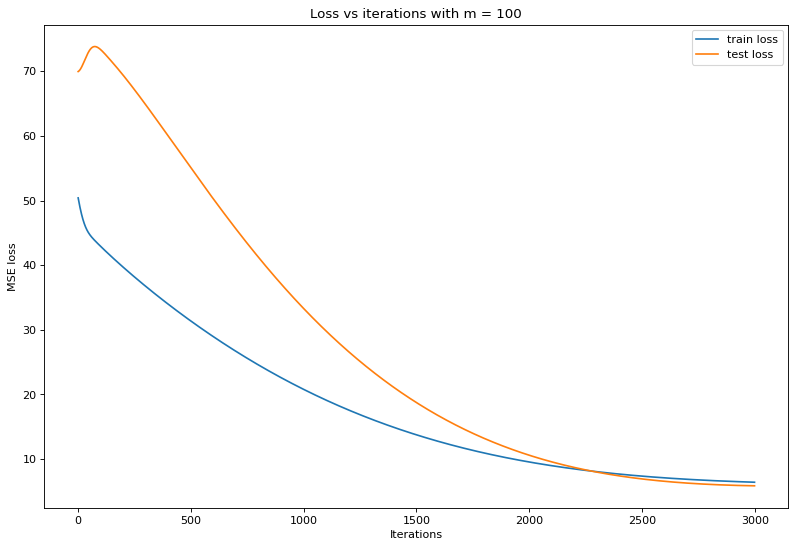

In [78]:
from cProfile import label


plt.plot(all_loss_values, label = 'train loss')
plt.plot(all_test_loss_values, label = 'test loss')
plt.title("Loss vs iterations with m = {}".format(m))
plt.xlabel("Iterations")
plt.ylabel("MSE loss")
plt.legend()
# plt.xscale('log')
plt.show()

Ep shape is (400, 1)
Shapes: x = (20,), X = (20, 20), DT = (400, 2), Ep = (400, 1), Zp = (20, 20)


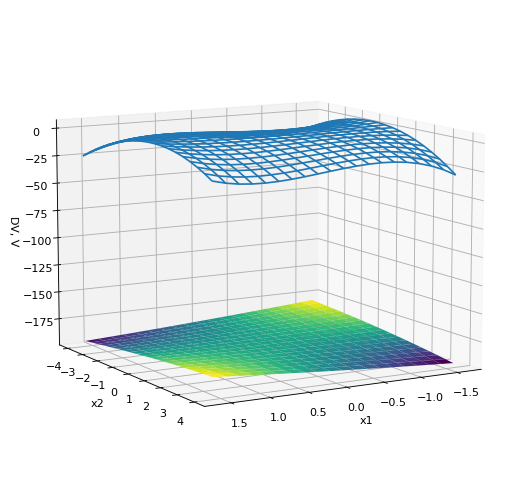

In [76]:
###### plot result ######

# define resolution
numpoints = 20

# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

# x = np.linspace(-1, bounds[0], numpoints)
# y = np.linspace(-1, bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,dim))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;

# evaluate model (= Lyapunov function values V)
Ep = model.predict(DT)
intermediate_output2 = tf.keras.Model(model.input, model.get_layer('output_layer').output)
# Ep = intermediate_output2(DT)
print('Ep shape is {}'.format(Ep.shape))
# print('Eq shape is {}'.format(Eq.shape))


# convert point vector to tensor for evaluating x-derivative
tDT = tf.convert_to_tensor(DT, dtype=tf.float32)

# evaluate gradients DV of Lyapunov function
with tf.GradientTape() as tape:
    tape.watch(tDT)
    ypm = model(tDT)
    grads = tape.gradient(ypm, tDT)

# compute orbital derivative DVf
Ee = tf.math.reduce_sum(grads*tf.transpose(tf.convert_to_tensor(vf(DT), dtype=tf.float32)), axis=1)

# copy V and DVf values into plottable format
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        Ze[i,j] = Ee[c]
        Zp[i,j] = Ep[c]
        c = c+1;


# define vector field for plot
new_vf = np.reshape(np.array(vf(DT)), (dim, numpoints, numpoints))

print('Shapes: x = {}, X = {}, DT = {}, Ep = {}, Zp = {}'.format(
    x.shape, X.shape, DT.shape, Ep.shape, Zp.shape
))

# define figure
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

# ax.set_title('m = {}'.format(m))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('DV, V');

# plot values V
ax.plot_surface(X, Y, Zp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

# plot orbital derivative DVf
ax.plot_wireframe(X, Y, Ze, rstride=1, cstride=1)

# change angles to see graph more clearly
# ax.view_init(-140, 60)
ax.view_init(10, 60)

# plt.savefig('Plots/van_3dplot.pdf')
plt.show()


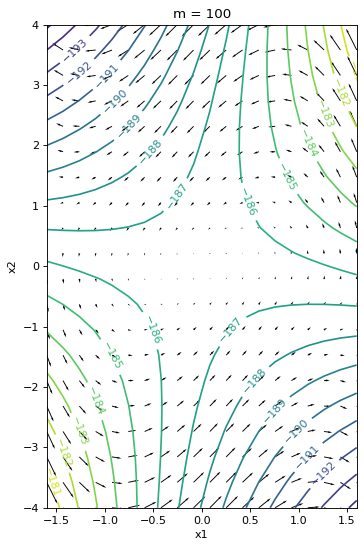

In [77]:
# import seaborn as sns
# sns.set_theme() # specify a theme
# sns.set_style({'axes.grid' : False})
plt.figure(figsize=(5,8))
cp = plt.contour(x,y,Zp, levels=15)
plt.quiver(X,Y, new_vf[0], new_vf[1], headwidth=2, headlength=4)
plt.clabel(cp, inline=True, fontsize=10)
plt.title('m = {}'.format(m))
plt.xlabel('x1')
plt.ylabel('x2')
# plt.savefig('Plots/vanpol2.pdf')
plt.show()